In [5]:
import os
import cv2
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

print("Path to dataset files:", path)

100%|██████████| 71.5M/71.5M [00:03<00:00, 24.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1


In [2]:
import os

# Path to the dataset directory in Google Colab
directory_path = "/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1"

# List all files and folders in the directory
for root, dirs, files in os.walk(directory_path):
    print("Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files)
    print("-" * 40)


Directory: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1
Subdirectories: ['Combined Dataset']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset
Subdirectories: ['test', 'train']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/test
Subdirectories: ['Very Mild Impairment', 'No Impairment', 'Moderate Impairment', 'Mild Impairment']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/test/Very Mild Impairment
Subdirectories: []
Files: ['1 (22).jpg', '16 (4).jpg', '11 (44).jpg', '4 (44).jpg', '25 (37).jpg', '4 (48).jpg', '9 (59).jpg', '16 (59).jpg', '30 (11).jpg', '19 (24).jpg', '23 (19).j

In [3]:
# Defining training & testing data paths using raw strings for Google Colab
train_data_path = "/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/train"
test_data_path = "/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/test"


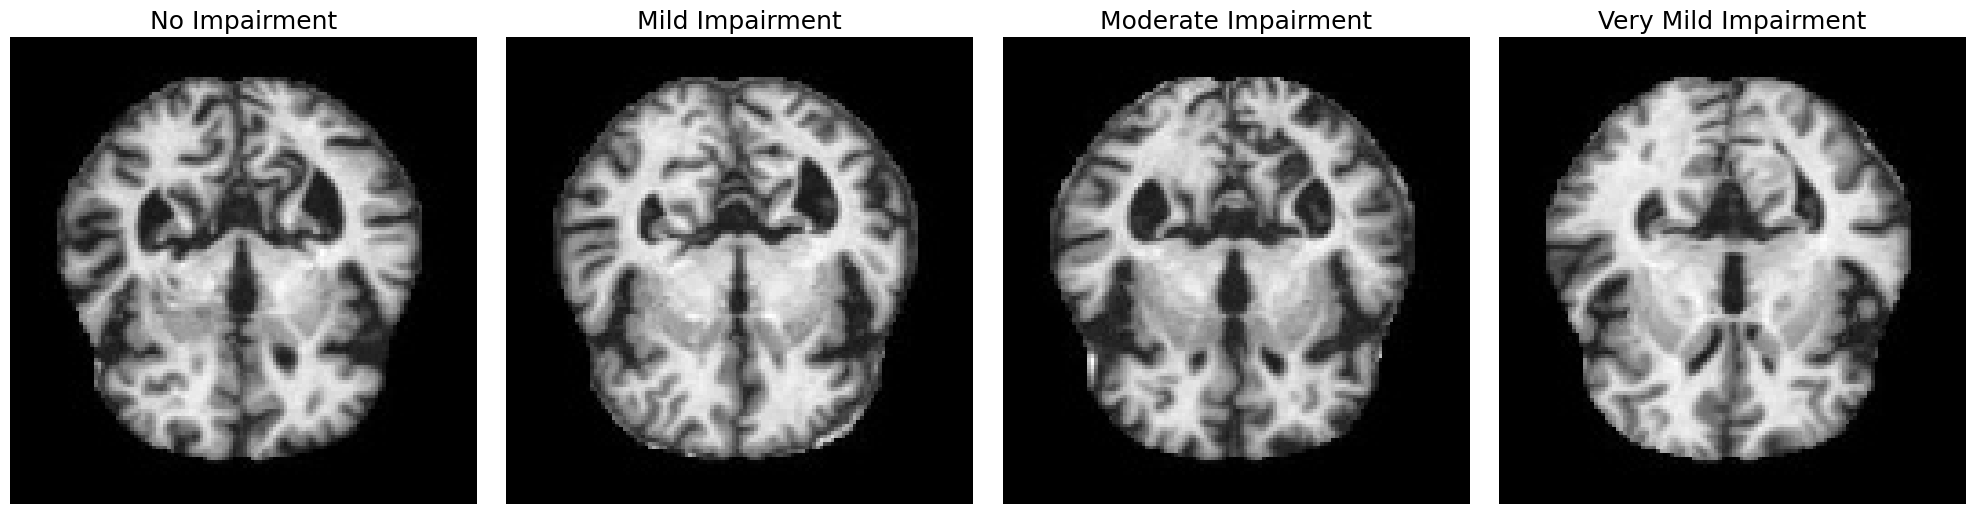

In [6]:
no_impairment = imread(train_data_path+"/No Impairment"+"/NoImpairment (1).jpg")
mild_impairment = imread(train_data_path+"/Mild Impairment"+"/MildImpairment (1).jpg")
moderate_impairment = imread(train_data_path+"/Moderate Impairment"+"/ModerateImpairment (1).jpg")
very_mild_impairment = imread(train_data_path+"/Very Mild Impairment"+"/VeryMildImpairment (1).jpg")


# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes = axes.flatten()

axes[0].imshow(no_impairment, cmap='gray')
axes[0].set_title('No Impairment', fontsize=18)
axes[0].axis('off')

axes[1].imshow(mild_impairment, cmap='gray')
axes[1].set_title('Mild Impairment', fontsize=18)
axes[1].axis('off')

axes[2].imshow(moderate_impairment, cmap='gray')
axes[2].set_title('Moderate Impairment', fontsize=18)
axes[2].axis('off')

axes[3].imshow(very_mild_impairment, cmap='gray')
axes[3].set_title('Very Mild Impairment', fontsize=18)
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [7]:
random_image=train_data_path+"/No Impairment"+"/NoImpairment (1).jpg"
print("Image Shape:",cv2.imread(random_image).shape)

Image Shape: (128, 128, 3)


In [8]:
def data_preprocessing(output_size, val_split=0.1):
    # ImageDataGenerator for training with validation split
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       zoom_range=0.2,
                                       shear_range=0.2,
                                       rotation_range=15,
                                       fill_mode='nearest',
                                       horizontal_flip=True,
                                       validation_split=val_split)

    # Training data generator
    training_set = train_datagen.flow_from_directory(train_data_path,
                                                     target_size=(output_size, output_size),
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     shuffle=True,
                                                     subset='training')

    # Validation data generator
    validation_set = train_datagen.flow_from_directory(train_data_path,
                                                       target_size=(output_size, output_size),
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       subset='validation')

    return training_set, validation_set


# Splitting Data
training_set, validation_set = data_preprocessing(output_size=150, val_split=0.1)


Found 9216 images belonging to 4 classes.
Found 1024 images belonging to 4 classes.


In [9]:
print("Training set distribution:", dict(pd.Series(training_set.classes).value_counts()))
print("\nValidation set distribution:", dict(pd.Series(validation_set.classes).value_counts()))

Training set distribution: {0: 2304, 1: 2304, 2: 2304, 3: 2304}

Validation set distribution: {0: 256, 1: 256, 2: 256, 3: 256}




### **Explanation of Code**
1. **Fuzzy Membership Function (`fuzzy_membership`)**:
   - Implements Gaussian membership functions to calculate how strongly an input belongs to each class.
   - Membership values are normalized to ensure their sum equals 1 (as required for probabilities).

2. **Custom Fuzzy Layer**:
   - Processes the output of the dense layer using fuzzy logic.
   - Maps the input to fuzzy membership values.

3. **Integration with VGG16**:
   - The fuzzy layer is placed after a dense layer, which reduces the feature representation to a scalar value for membership evaluation.
   - The final output layer applies softmax to classify the image based on fuzzy memberships.

4. **Interpretability**:
   - The fuzzy membership values provide insights into how well the input fits into each class.
   - This enhances the model’s transparency, particularly for ambiguous or uncertain predictions.

---

### **Advantages of This Approach**
- Handles **uncertainty** better by assigning partial membership to classes.
- Improves **interpretability**, crucial for medical applications like MRI classification.
- Retains the power of deep learning while incorporating fuzzy logic's reasoning capabilities.

You can further refine the fuzzy membership functions (e.g., triangular, trapezoidal) and tune the parameters (`centers`, `sigma`) based on the specifics of your dataset.

In [16]:
# Load the pre-trained VGG16 model (excluding the top layers) with weights from ImageNet
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of VGG16 so that they are not trainable
vgg_base.trainable = False

# Initialize the Sequential model
model = Sequential([
    # VGG16 as the base feature extractor
    vgg_base,

    # Flatten the output of the VGG16 base
    Flatten(),

    # Fully Connected Layer 1
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Fully Connected Layer 2
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),


    # Output Layer with Softmax Activation (for 4 classes)
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,847,044 (64.27 MB)

 Trainable params: 2,131,588 (8.13 MB)

 Non-trainable params: 14,715,456 (56.14 MB)

The **fuzzy output** represents the degree of membership of the input image to each of the 4 classes based on the fuzzy logic layer. Each value in the output corresponds to the likelihood of the input belonging to a specific class, calculated using the **fuzzy membership functions**. Here's how to interpret it step-by-step:

---

### **Structure of the Output**
The fuzzy output is a **4D tensor**:
1. **Batch Dimension**: The outermost brackets (`[[[]]]`) indicate that the model processed a batch of 1 image.
2. **Spatial Dimensions**: The second and third levels (`[[...]]`) represent the height and width of the feature map processed by the fuzzy layer.
3. **Class Memberships**: Each innermost array (`[val1, val2, val3, val4]`) corresponds to the **fuzzy memberships for the 4 classes**.

For example:
- `[0.24944778, 0.25026643, 0.24876195, 0.25152382]` indicates:
  - Membership to class 1 ≈ 0.249
  - Membership to class 2 ≈ 0.250
  - Membership to class 3 ≈ 0.249
  - Membership to class 4 ≈ 0.252

---

### **What It Represents**
1. **Probabilistic Interpretation**:
   - Each value is a fuzzy membership degree, similar to a probability, normalized to ensure the sum is 1.
   - Higher membership values indicate stronger association with a particular class.

2. **Uncertainty**:
   - If the memberships are close in value (like the first array), it suggests **uncertainty** or overlap between classes.
   - For example, `[0.249, 0.250, 0.249, 0.252]` indicates the model is unsure which class the input belongs to.

3. **Spatial Mapping**:
   - The output contains multiple membership arrays corresponding to spatial locations in the feature map.
   - Each spatial location is evaluated for its membership in all classes, providing localized fuzzy classification.

---

### **Interpretation of Your Specific Output**
1. **Array 1** (`[0.24944778, 0.25026643, 0.24876195, 0.25152382]`):
   - Very close membership values for all classes.
   - The model perceives significant ambiguity; the input might share features across all 4 classes equally.

2. **Array 2** (`[0.22592859, 0.25739098, 0.20248458, 0.31419584]`):
   - Higher membership for class 4 (≈ 0.314) and class 2 (≈ 0.257).
   - Suggests that this region of the feature map is more likely associated with these two classes.

3. **Array 3** (`[0.23284803, 0.25605857, 0.2149792, 0.29611418]`):
   - Similar to Array 2, with slightly higher membership for class 4 (≈ 0.296).

4. **Array 4** (`[0.24978657, 0.25010362, 0.2495205, 0.2505893]`):
   - Almost equal membership for all classes.
   - Indicates uncertainty, with no dominant class.

---

### **Use Cases for This Output**
1. **Interpretability**:
   - Provides insights into how confidently the model assigns regions to classes, useful for medical imaging where ambiguity is common.
   - Allows experts to understand **why** certain predictions were made.

2. **Post-processing**:
   - Combine fuzzy memberships across spatial locations to derive the overall class membership for the image.
   - Use the membership scores to handle uncertain predictions by considering secondary classes.

3. **Improving Classification**:
   - Use ambiguous memberships (like those in Array 1 and Array 4) to trigger additional processing, such as reviewing or augmenting the dataset for similar cases.

---



In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Training the model
history = model.fit(training_set, validation_data = validation_set, batch_size = 64, epochs= 20, verbose = 1)

Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 65s 222ms/step - accuracy: 0.7964 - loss: 0.4846 - val_accuracy: 0.7295 - val_loss: 0.5885
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 80s 214ms/step - accuracy: 0.8072 - loss: 0.4682 - val_accuracy: 0.7373 - val_loss: 0.5808
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 67s 230ms/step - accuracy: 0.8088 - loss: 0.4510 - val_accuracy: 0.7471 - val_loss: 0.5623
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 63s 214ms/step - accuracy: 0.7996 - loss: 0.4796 - val_accuracy: 0.7354 - val_loss: 0.6086
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 82s 216ms/step - accuracy: 0.8171 - loss: 0.4519 - val_accuracy: 0.7490 - val_loss: 0.6225
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 62s 213ms/step - accuracy: 0.8113 - loss: 0.4484 - val_accuracy: 0.7549 - val_loss: 0.5143
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.8234 - loss: 0.4323 - val_accuracy: 0.7334 - val_loss: 0.6018
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 63s 214ms/step - accuracy: 0.8117 - loss: 0

In [20]:
import numpy as np
import tensorflow as tf
from scipy.stats import norm  # For Gaussian membership functions


# Define fuzzy membership function
def apply_fuzzy_logic(probabilities):
    """
    Apply fuzzy membership functions to model predictions.

    Parameters:
    probabilities (np.array): Array of class probabilities from the model.

    Returns:
    np.array: Array of fuzzy membership values for each class.
    """
    # Define Gaussian membership centers (can be tuned as needed)
    centers = [0.25, 0.5, 0.75, 1.0]  # Hypothetical centers for fuzzy sets
    sigma = 0.2  # Standard deviation for Gaussian membership

    # Apply Gaussian membership for each class probability
    fuzzy_memberships = []
    for prob in probabilities:
        memberships = [norm.pdf(prob, loc=center, scale=sigma) for center in centers]
        memberships = np.array(memberships)
        memberships /= memberships.sum()  # Normalize to ensure they sum to 1
        fuzzy_memberships.append(memberships)

    return np.array(fuzzy_memberships)

# # Apply fuzzy logic to the model output
# fuzzy_output = apply_fuzzy_logic(model_output)

# # Display the fuzzy membership scores
# print("Model Output (Softmax Probabilities):")
# print(model_output)
# print("\nFuzzy Membership Scores:")
# print(fuzzy_output)


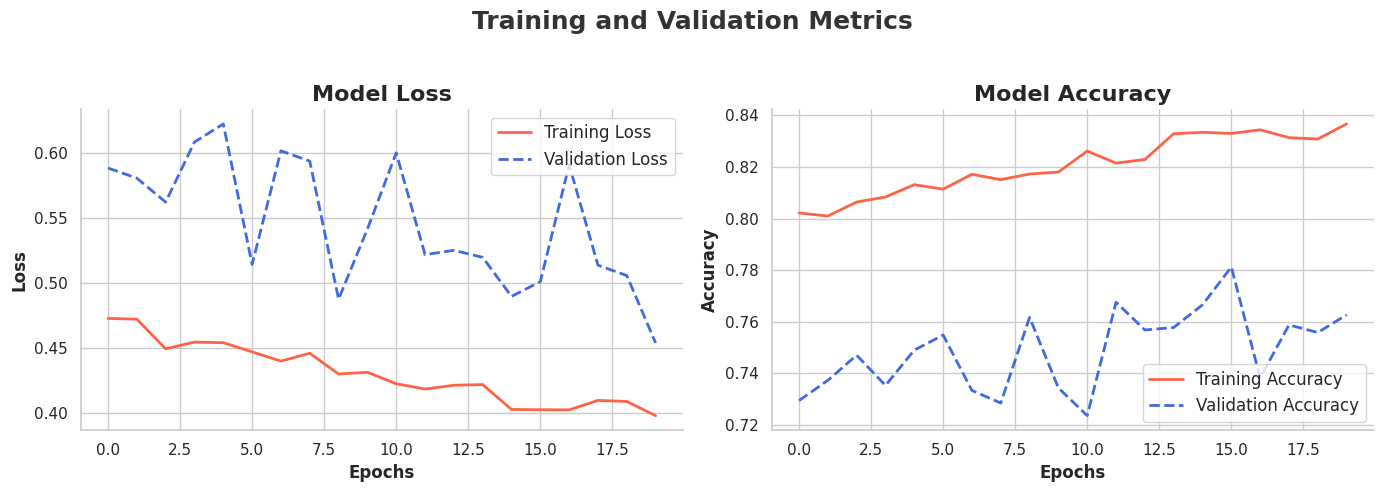

In [21]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plotting Loss
axes[0].plot(history.history['loss'], color='#FF6347', label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], color='#4169E1', label='Validation Loss', linewidth=2, linestyle='--')
axes[0].set_title('Model Loss', fontsize=16, weight='bold')
axes[0].set_xlabel('Epochs', fontsize=12, weight='bold')
axes[0].set_ylabel('Loss', fontsize=12, weight='bold')
axes[0].legend(loc='upper right', fontsize=12)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plotting Accuracy
axes[1].plot(history.history['accuracy'], color='#FF6347', label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], color='#4169E1', label='Validation Accuracy', linewidth=2, linestyle='--')
axes[1].set_title('Model Accuracy', fontsize=16, weight='bold')
axes[1].set_xlabel('Epochs', fontsize=12, weight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, weight='bold')
axes[1].legend(loc='lower right', fontsize=12)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)


plt.suptitle('Training and Validation Metrics', fontsize=18, weight='bold', color='#333')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(test_data_path,
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

# Print the test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 1279 images belonging to 4 classes.
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 299ms/step - accuracy: 0.6941 - loss: 0.6314
Test Loss: 0.6166
Test Accuracy: 71.23%


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from scipy.stats import norm

# Define the fuzzy logic function
def apply_fuzzy_logic(probabilities):
    """
    Apply fuzzy membership functions to model predictions.

    Parameters:
    probabilities (np.array): Array of class probabilities from the model.

    Returns:
    np.array: Array of fuzzy membership values for each class.
    """
    # Define Gaussian membership centers and sigma
    centers = [0.25, 0.5, 0.75, 1.0]  # Example fuzzy set centers
    sigma = 0.2  # Standard deviation for Gaussian membership

    # Apply Gaussian membership for each class probability
    fuzzy_memberships = []
    for prob in probabilities:
        memberships = [norm.pdf(prob, loc=center, scale=sigma) for center in centers]
        memberships = np.array(memberships)
        memberships /= memberships.sum()  # Normalize to ensure they sum to 1
        fuzzy_memberships.append(memberships)

    return np.round(np.array(fuzzy_memberships), 2)

# Test set preparation
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(test_data_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=True)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

# Print the test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions for the entire test set
test_set.reset()  # Reset generator to ensure correct predictions
predictions = model.predict(test_set, verbose=1)

# Apply fuzzy logic to the predictions
fuzzy_outputs = np.array([apply_fuzzy_logic(probs) for probs in predictions])

# Display a sample of predictions and their fuzzy memberships
for i, (softmax_probs, fuzzy_memberships) in enumerate(zip(predictions[:5], fuzzy_outputs[:5])):
    print(f"Sample {i + 1}:")
    print(f"  Softmax Probabilities: {softmax_probs}")
    print(f"  Fuzzy Memberships: {fuzzy_memberships}")


Found 1279 images belonging to 4 classes.
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7123 - loss: 0.6190
Test Loss: 0.6166
Test Accuracy: 71.23%
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
Sample 1:
  Softmax Probabilities: [9.1023588e-01 1.8755576e-06 4.9323369e-02 4.0438935e-02]
  Fuzzy Memberships: [[0.   0.07 0.41 0.51]
 [0.91 0.09 0.   0.  ]
 [0.88 0.12 0.   0.  ]
 [0.89 0.11 0.   0.  ]]
Sample 2:
  Softmax Probabilities: [1.3893105e-01 9.4386509e-05 3.9888158e-01 4.6209300e-01]
  Fuzzy Memberships: [[0.81 0.18 0.01 0.  ]
 [0.91 0.09 0.   0.  ]
 [0.41 0.47 0.11 0.01]
 [0.29 0.51 0.18 0.01]]
Sample 3:
  Softmax Probabilities: [5.6494538e-02 3.5153277e-04 2.6871544e-01 6.7443848e-01]
  Fuzzy Memberships: [[0.88 0.12 0.   0.  ]
 [0.91 0.09 0.   0.  ]
 [0.64 0.33 0.04 0.  ]
 [0.05 0.34 0.47 0.13]]
Sample 4:
  Softmax Probabilities: [4.4932973e-02 2.9685953e-05 5.1101536e-01 4.4402200e-01]
  Fuzzy Memberships: [[0.88 0.11 0.   0.  ]
 [0.91 0.09 0.   0.  ]
 [0.22 0.51 0.25 0.03]


In [25]:
# Function for making predictions
def prediction1(img_path, class_labels):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to class labels
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]

    return predicted_class, prediction[0]

In [26]:
from tensorflow.keras.preprocessing import image
import numpy as np
from scipy.stats import norm

# Define the fuzzy logic function
def apply_fuzzy_logic(probabilities):
    """
    Apply fuzzy membership functions to model predictions.

    Parameters:
    probabilities (np.array): Array of class probabilities from the model.

    Returns:
    np.array: Array of rounded fuzzy membership values for each class.
    """
    # Define Gaussian membership centers and sigma
    centers = [0.25, 0.5, 0.75, 1.0]  # Example fuzzy set centers
    sigma = 0.2  # Standard deviation for Gaussian membership

    # Apply Gaussian membership for each class probability
    fuzzy_memberships = []
    for prob in probabilities:
        memberships = [norm.pdf(prob, loc=center, scale=sigma) for center in centers]
        memberships = np.array(memberships)
        memberships /= memberships.sum()  # Normalize to ensure they sum to 1
        fuzzy_memberships.append(memberships)

    # Round off fuzzy memberships to 2 decimal places
    return np.round(np.array(fuzzy_memberships), 2)

# Prediction function with fuzzy logic
def prediction(img_path, class_labels):
    """
    Make a prediction on an image and apply fuzzy logic to the model's output.

    Parameters:
    img_path (str): Path to the image file to predict.
    class_labels (list): List of class labels for classification.

    Returns:
    predicted_class (str): The predicted class label.
    fuzzy_memberships (np.array): The fuzzy membership values for the predicted class.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make the prediction
    prediction = model.predict(img_array)

    # Convert the prediction to class labels
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]

    # Apply fuzzy logic to the predicted class probabilities
    fuzzy_memberships = apply_fuzzy_logic(prediction[0])

    return predicted_class, fuzzy_memberships



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
                                          Image Path            True Class  \
0  /root/.cache/kagglehub/datasets/lukechugh/best...       Mild Impairment   
1  /root/.cache/kagglehub/datasets/lukechugh/best...       Mild Impairment   
2  /root/.cache/kagglehub/datasets/lukechugh/best...   Moderate Impairment   
3  /root/.cache/kagglehub/datasets/lukechugh/best...   Moderate Impairment   
4  /root/.cache/kagglehub/datasets/lukechugh/best...         No Impairment   
5  /root/.cache/kagglehub/datasets/lukechugh/best...         No Impairment   
6  /root/.cache/kagglehub/datasets/lukechugh/best...  Very Mild Impairment   
7  /root/.cache/kagglehub/datasets/lukechugh/best...  Very Mild Impairme

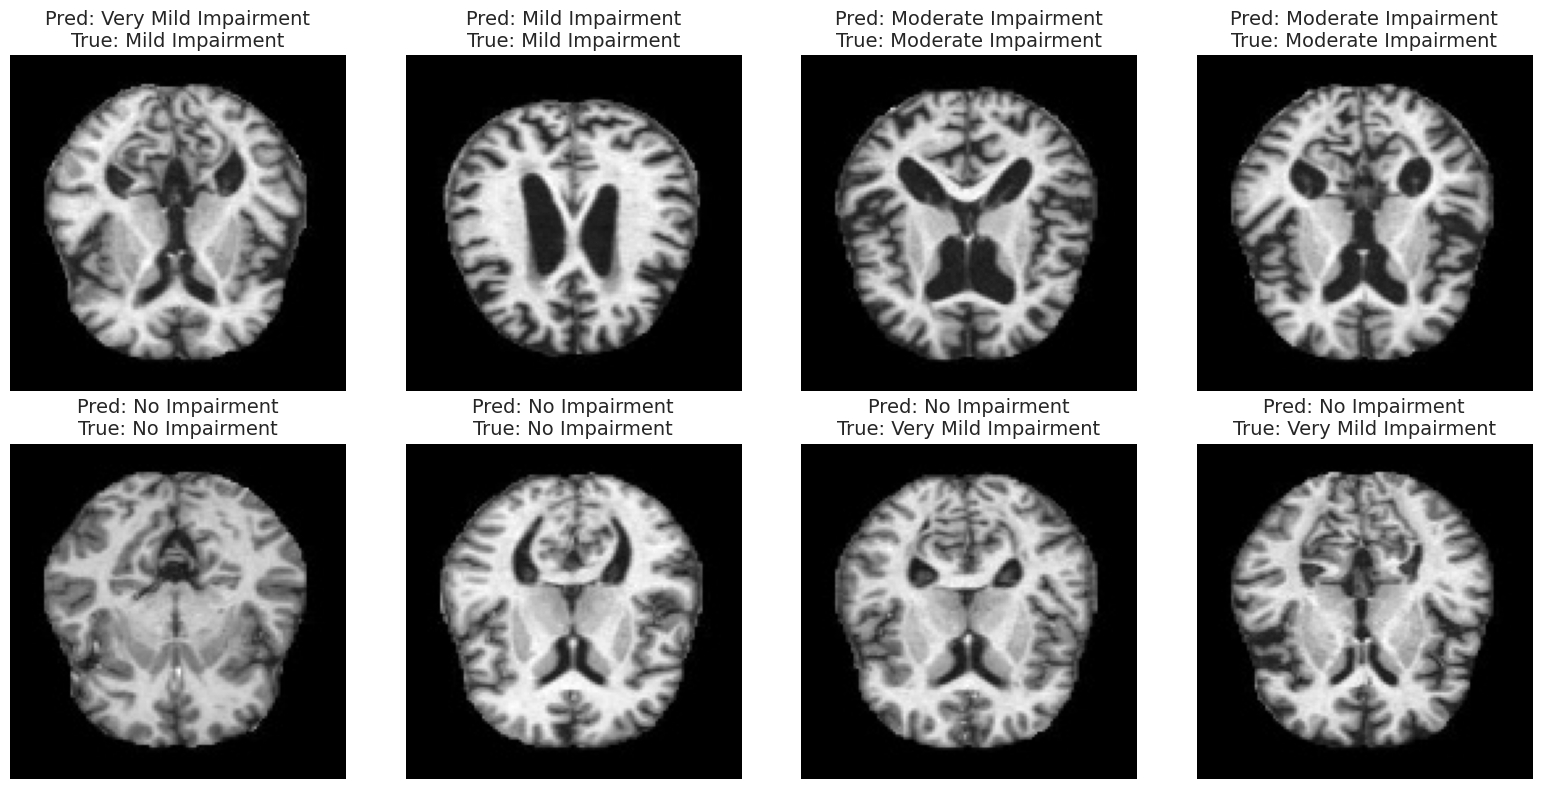

In [28]:
folder_path = "/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/test"
class_labels = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Prepare a list to store file paths and corresponding class names
image_paths = []
class_names = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

for class_name in class_names:
    class_folder = os.path.join(folder_path, class_name)
    image_files = os.listdir(class_folder)
    selected_images = random.sample(image_files, 2)  # Randomly select 2 images
    for img_file in selected_images:
        image_paths.append((os.path.join(class_folder, img_file), class_name))

# Prepare a list to store the results (including fuzzy memberships)
results = []

# Create the plot for displaying images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Loop through the images, make predictions, and display results
for i, (img_path, true_class) in enumerate(image_paths):
    predicted_class, fuzzy_memberships = prediction(img_path, class_labels)
    img = plt.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Pred: {predicted_class}\nTrue: {true_class}", fontsize=14)

    # Store the result for this image, including the fuzzy memberships
    result = {
        "Image Path": img_path,
        "True Class": true_class,
        "Predicted Class": predicted_class,
        "Fuzzy Memberships": fuzzy_memberships.tolist()  # Convert fuzzy memberships to list for saving
    }
    results.append(result)

# Save the results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv("/root/.cache/kagglehub/fuzzy_predictions.csv", index=False)

# Print the results DataFrame to check the contents
print(results_df)

# Show the plot
plt.tight_layout()
plt.show()

In [29]:
results_df

,Image Path,True Class,Predicted Class,Fuzzy Memberships
0,/root/.cache/kagglehub/datasets/lukechugh/best...,Mild Impairment,Very Mild Impairment,"[[0.76, 0.22, 0.01, 0.0], [0.91, 0.09, 0.0, 0...."
1,/root/.cache/kagglehub/datasets/lukechugh/best...,Mild Impairment,Mild Impairment,"[[0.16, 0.49, 0.31, 0.04], [0.91, 0.09, 0.0, 0..."
2,/root/.cache/kagglehub/datasets/lukechugh/best...,Moderate Impairment,Moderate Impairment,"[[0.91, 0.09, 0.0, 0.0], [0.11, 0.44, 0.38, 0...."
3,/root/.cache/kagglehub/datasets/lukechugh/best...,Moderate Impairment,Moderate Impairment,"[[0.91, 0.09, 0.0, 0.0], [0.0, 0.04, 0.33, 0.6..."
4,/root/.cache/kagglehub/datasets/lukechugh/best...,No Impairment,No Impairment,"[[0.91, 0.09, 0.0, 0.0], [0.91, 0.09, 0.0, 0.0..."
5,/root/.cache/kagglehub/datasets/lukechugh/best...,No Impairment,No Impairment,"[[0.91, 0.09, 0.0, 0.0], [0.91, 0.09, 0.0, 0.0..."
6,/root/.cache/kagglehub/datasets/lukechugh/best...,Very Mild Impairment,No Impairment,"[[0.91, 0.09, 0.0, 0.0], [0.91, 0.09, 0.0, 0.0..."
7,/root/.cache/kagglehub/datasets/lukechugh/best...,Very Mild Impairment,No Impairment,"[[0.9, 0.1, 0.0, 0.0], [0.91, 0.09, 0.0, 0.0],..."


Generation 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/st

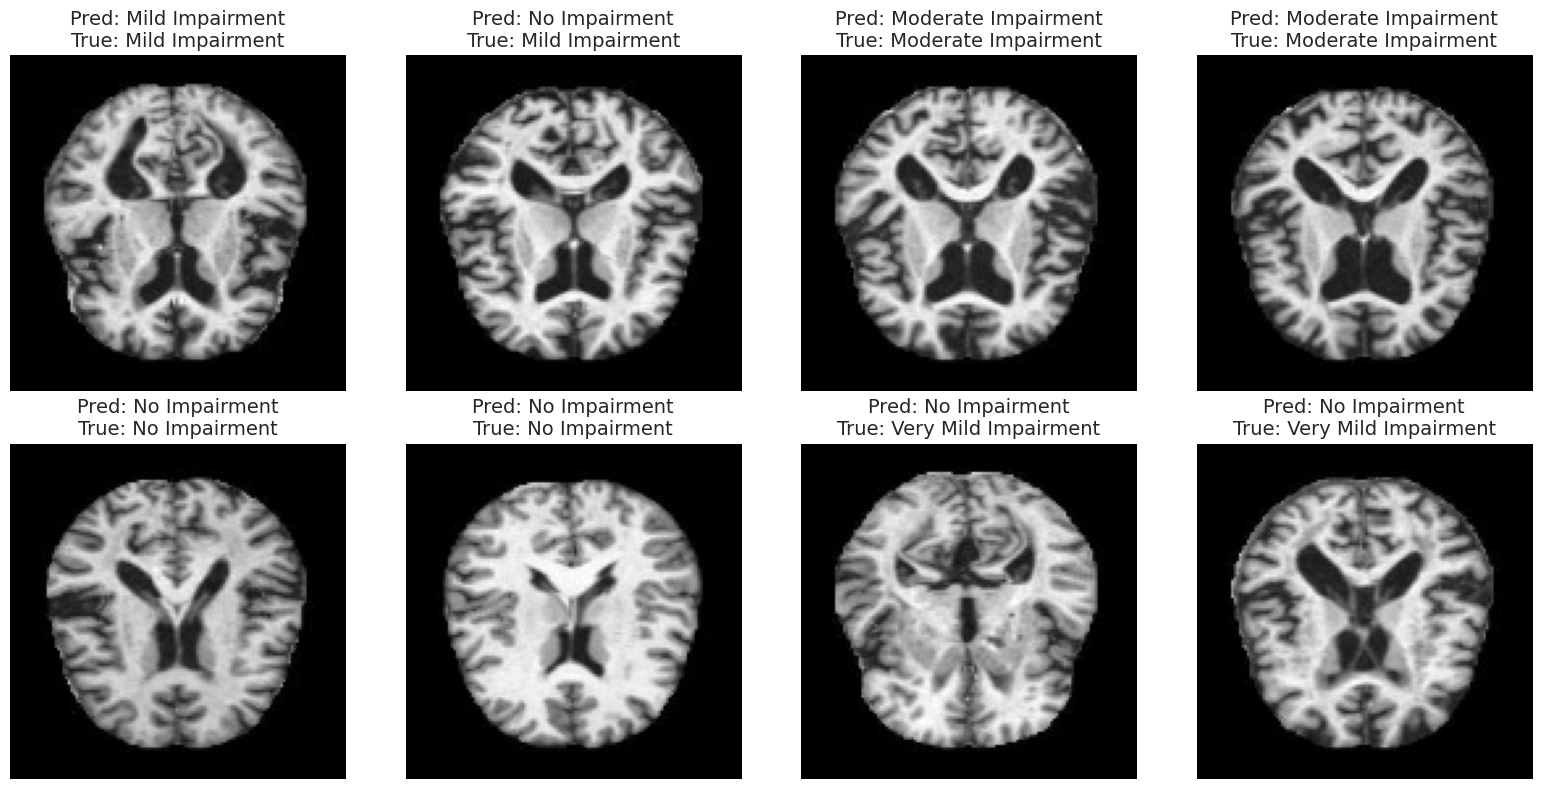

In [31]:
import random
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt

# Define the population size, number of generations, mutation rate, and other GA parameters
POPULATION_SIZE = 10
NUM_GENERATIONS = 5
MUTATION_RATE = 0.1

# Define the number of classes (we have 4 classes)
NUM_CLASSES = 4

# Define class labels
class_labels = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Fitness function to evaluate the GA population
def fitness_function(individual, image_paths, class_labels):
    """
    Evaluate the fitness of an individual. This individual represents the fuzzy thresholds or coefficients for prediction adjustment.
    The fitness is determined by how well the predictions match the true classes using the fuzzy logic.
    """
    correct_predictions = 0
    total_predictions = len(image_paths)

    for img_path, true_class in image_paths:
        predicted_class, fuzzy_memberships = prediction_with_fuzzy_adjustment(img_path, individual, class_labels)
        if predicted_class == true_class:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

# Modify prediction function to adjust using fuzzy membership
def prediction_with_fuzzy_adjustment(img_path, fuzzy_params, class_labels):
    """
    Modify the prediction by adjusting the fuzzy memberships based on the fuzzy_params (GA individual).
    """
    # Load the image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make the prediction using the trained model
    prediction = model.predict(img_array)

    # Apply fuzzy logic to get the fuzzy membership values
    fuzzy_memberships = fuzzy_logic_with_params(prediction[0], fuzzy_params)

    # Convert the prediction to class labels
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]

    return predicted_class, fuzzy_memberships

# Fuzzy logic with parameters adjustment based on GA individual
def fuzzy_logic_with_params(predictions, fuzzy_params):
    """
    Adjust the fuzzy memberships based on the parameters from the GA (fuzzy_params).
    """
    fuzzy_values = [pred * fuzzy_params[i] for i, pred in enumerate(predictions)]
    total = sum(fuzzy_values)
    if total > 1:  # Normalize if total exceeds 1
        fuzzy_values = [val / total for val in fuzzy_values]
    return fuzzy_values

# Define mutation function to randomly change fuzzy membership weights
def mutate(individual):
    mutation_point = random.randint(0, NUM_CLASSES - 1)
    mutation_value = random.uniform(0.8, 1.2)  # Random adjustment factor
    individual[mutation_point] *= mutation_value
    return individual

# Define crossover function to combine two individuals (fuzzy_params)
def crossover(individual1, individual2):
    crossover_point = random.randint(0, NUM_CLASSES - 1)
    new_individual = individual1[:crossover_point] + individual2[crossover_point:]
    return new_individual

# Create the initial population for GA
def create_initial_population():
    population = []
    for _ in range(POPULATION_SIZE):
        individual = [random.uniform(0.5, 1.5) for _ in range(NUM_CLASSES)]  # Random parameters
        population.append(individual)
    return population

# Run the genetic algorithm
def run_ga(image_paths, class_labels):
    population = create_initial_population()

    for generation in range(NUM_GENERATIONS):
        print(f"Generation {generation + 1}/{NUM_GENERATIONS}")

        # Evaluate the fitness of each individual
        fitness_values = [fitness_function(ind, image_paths, class_labels) for ind in population]

        # Select the best individuals (tournament selection)
        selected_parents = [population[i] for i in np.argsort(fitness_values)[-POPULATION_SIZE // 2:]]

        # Create the next generation through crossover and mutation
        next_population = []
        while len(next_population) < POPULATION_SIZE:
            parent1, parent2 = random.sample(selected_parents, 2)
            offspring = crossover(parent1, parent2)
            if random.random() < MUTATION_RATE:
                offspring = mutate(offspring)
            next_population.append(offspring)

        population = next_population

    # Get the best individual after all generations
    best_individual = population[np.argmax(fitness_values)]
    return best_individual

# Define the folder path for the test images
folder_path = "/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/test"
class_names = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Prepare a list to store image paths and corresponding class names
image_paths = []
for class_name in class_names:
    class_folder = os.path.join(folder_path, class_name)
    image_files = os.listdir(class_folder)
    selected_images = random.sample(image_files, 2)  # Randomly select 2 images
    for img_file in selected_images:
        image_paths.append((os.path.join(class_folder, img_file), class_name))

# Run the Genetic Algorithm to optimize fuzzy membership values
best_fuzzy_params = run_ga(image_paths, class_labels)

# Store results of predictions using the optimized fuzzy parameters
results = []

# Create the plot for displaying images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Loop through the images and make predictions using the optimized fuzzy parameters
for i, (img_path, true_class) in enumerate(image_paths):
    predicted_class, fuzzy_memberships = prediction_with_fuzzy_adjustment(img_path, best_fuzzy_params, class_labels)
    img = plt.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Pred: {predicted_class}\nTrue: {true_class}", fontsize=14)

    # Store the result for this image
    result = {
        "Image Path": img_path,
        "True Class": true_class,
        "Predicted Class": predicted_class,
        "Fuzzy Memberships": fuzzy_memberships
    }
    results.append(result)

# Save the results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv("/root/.cache/kagglehub/fuzzy_ga_predictions.csv", index=False)

# Show the results and plot
print(results_df)
plt.tight_layout()
plt.show()


To integrate a **Genetic Algorithm (GA)** with the existing setup, we will use GA to optimize the fuzzy logic approach for the predictions or optimize the overall performance of the model by adjusting hyperparameters or weights. Here's an outline of how we can apply a Genetic Algorithm to this problem:

### **Steps to Apply GA:**

1. **Define the Problem**: Use GA to optimize the fuzzy membership values or the final classification decision (for instance, deciding how fuzzy logic will adjust the class prediction based on membership values).

2. **GA Population Representation**:
   - Each individual in the population can represent a possible set of fuzzy membership thresholds or the weights used in the fuzzy logic system.
   - For example, the individual might contain a set of coefficients that modify the predictions based on their fuzzy membership values.

3. **Fitness Function**: The fitness function evaluates how well an individual (i.e., a set of fuzzy logic adjustments) performs by calculating the **accuracy** (or some other performance metric like F1-score or loss) based on the fuzzy logic adjustments to the predictions.

4. **Genetic Operators**:
   - **Selection**: Choose the best-performing individuals based on fitness.
   - **Crossover**: Combine two individuals to create new individuals.
   - **Mutation**: Introduce slight random changes to individuals to explore new possibilities.

5. **Application of GA**: Apply the best solution from the genetic algorithm to adjust how fuzzy logic works on the model’s predictions.

### **Implementation Steps**:

1. **Define GA parameters**: Number of generations, population size, mutation rate, etc.
2. **Define the fitness function**: This will use fuzzy logic and measure the prediction accuracy.
3. **Apply GA to tune fuzzy logic**.

Here’s how you can apply a Genetic Algorithm (GA) for fuzzy membership tuning to the existing prediction code:

### **Genetic Algorithm (GA) for Fuzzy Membership Adjustment**

### **Explanation**:

1. **Genetic Algorithm (GA) Components**:
   - **Population**: Each individual in the population represents a set of fuzzy membership values (adjustments for each class). These values will influence how the fuzzy membership is computed in the prediction.
   - **Fitness Function**: This function evaluates the performance of an individual based on how well it predicts the correct class for the images using the fuzzy logic system.
   - **Crossover & Mutation**: These genetic operators combine individuals (parent fuzzy parameters) and introduce variations (mutations) to explore the solution space for better performance.
   
2. **Fuzzy Membership with GA**:
   - **Fuzzy Membership Adjustment**: The genetic algorithm adjusts the fuzzy membership parameters based on the fuzzy logic defined in the `fuzzy_logic_with_params` function.
   - This allows the GA to fine-tune the model's behavior and potentially improve its

In [34]:
import random
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt

# Define GA parameters
POPULATION_SIZE = 10
NUM_GENERATIONS = 5
MUTATION_RATE = 0.1

# Define the number of classes
NUM_CLASSES = 4

# Define class labels
class_labels = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Fitness function to evaluate GA population
def fitness_function(individual, image_paths, class_labels):
    """
    Evaluate the fitness of an individual. This individual represents fuzzy membership adjustments for predictions.
    """
    correct_predictions = 0
    total_predictions = len(image_paths)

    for img_path, true_class in image_paths:
        predicted_class, fuzzy_memberships = prediction_with_fuzzy_adjustment(img_path, individual, class_labels)
        if predicted_class == true_class:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

# Modify prediction function to adjust using fuzzy membership
def prediction_with_fuzzy_adjustment(img_path, fuzzy_params, class_labels):
    """
    Modify the prediction using fuzzy parameters obtained from GA.
    """
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize image

    # Make prediction using the model
    prediction = model.predict(img_array)

    # Apply fuzzy logic to adjust the prediction using GA parameters
    fuzzy_memberships = fuzzy_logic_with_params(prediction[0], fuzzy_params)

    # Convert the prediction to class labels
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_labels[predicted_class_index]

    return predicted_class, fuzzy_memberships

# Fuzzy logic with parameters adjustment
def fuzzy_logic_with_params(predictions, fuzzy_params):
    """
    Adjust the fuzzy memberships based on GA fuzzy parameters.
    """
    fuzzy_values = [pred * fuzzy_params[i] for i, pred in enumerate(predictions)]
    total = sum(fuzzy_values)
    if total > 1:  # Normalize if total exceeds 1
        fuzzy_values = [val / total for val in fuzzy_values]
    return fuzzy_values

# Define mutation function to randomly change fuzzy membership weights
def mutate(individual):
    mutation_point = random.randint(0, NUM_CLASSES - 1)
    mutation_value = random.uniform(0.8, 1.2)  # Random mutation factor
    individual[mutation_point] *= mutation_value
    return individual

# Crossover function to combine two individuals
def crossover(individual1, individual2):
    crossover_point = random.randint(0, NUM_CLASSES - 1)
    new_individual = individual1[:crossover_point] + individual2[crossover_point:]
    return new_individual

# Create initial population
def create_initial_population():
    population = []
    for _ in range(POPULATION_SIZE):
        individual = [random.uniform(0.5, 1.5) for _ in range(NUM_CLASSES)]  # Random fuzzy parameters
        population.append(individual)
    return population

# Run the genetic algorithm and track accuracy improvement
def run_ga(image_paths, class_labels):
    population = create_initial_population()

    accuracy_history = []  # To store the accuracy of each generation

    # Track the best individual
    best_accuracy = 0
    best_individual = None

    for generation in range(NUM_GENERATIONS):
        print(f"Generation {generation + 1}/{NUM_GENERATIONS}")

        # Evaluate the fitness of each individual in the population
        fitness_values = [fitness_function(ind, image_paths, class_labels) for ind in population]

        # Track the best accuracy in the generation
        generation_best_accuracy = max(fitness_values)
        accuracy_history.append(generation_best_accuracy)

        if generation_best_accuracy > best_accuracy:
            best_accuracy = generation_best_accuracy
            best_individual = population[np.argmax(fitness_values)]

        # Selection: Select the best-performing individuals (top 50%)
        selected_parents = [population[i] for i in np.argsort(fitness_values)[-POPULATION_SIZE // 2:]]

        # Create the next generation through crossover and mutation
        next_population = []
        while len(next_population) < POPULATION_SIZE:
            parent1, parent2 = random.sample(selected_parents, 2)
            offspring = crossover(parent1, parent2)
            if random.random() < MUTATION_RATE:
                offspring = mutate(offspring)
            next_population.append(offspring)

        population = next_population

    return best_individual, accuracy_history

# Define the folder path for the test images
folder_path = "/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/test"
class_names = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# Prepare a list of image paths and corresponding true class names
image_paths = []
for class_name in class_names:
    class_folder = os.path.join(folder_path, class_name)
    image_files = os.listdir(class_folder)
    selected_images = random.sample(image_files, 2)  # Randomly select 2 images
    for img_file in selected_images:
        image_paths.append((os.path.join(class_folder, img_file), class_name))

# Run the Genetic Algorithm
best_fuzzy_params, accuracy_history = run_ga(image_paths, class_labels)

# Save the best fuzzy parameters and the accuracy history to CSV
best_result = {
    "Best Fuzzy Parameters": best_fuzzy_params,
    "Best Accuracy": max(accuracy_history)
}
best_result_df = pd.DataFrame([best_result])
best_result_df.to_csv("/root/.cache/kagglehub/final_best_accuracy_ga.csv", index=False)

# Print the best result
print("Best Fuzzy Parameters:", best_fuzzy_params)
print("Best Accuracy:", max(accuracy_history))


Generation 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/st